In [1]:
import os
base_path = os.path.abspath("../")
os.chdir(base_path)

In [2]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings

warnings.simplefilter("ignore",UserWarning)

from lightgbm import LGBMRegressor

In [4]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import *
from causalml.propensity import calibrate

print(causalml.__version__)

0.9.0


In [8]:
logger = logging.getLogger("causalml")
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

# Generating Synthetic Data

In [12]:
# Output of synthetic_data function
# - y ((n,)-array): outcome variable.
# - X ((n,p)-ndarray): independent variables.
# - w ((n,)-array): treatment flag with value 0 or 1.
# - tau ((n,)-array): individual treatment effect.
# - b ((n,)-array): expected outcome.
# - e ((n,)-array): propensity of receiving treatment.

y, X, treatment, tau, b, e = synthetic_data(mode = 1, n = 1000000, p = 10, sigma = 5.)

In [14]:
X_train, X_test, y_train, y_test, e_train, e_test, treatment_train, treatment_test, tau_train, tau_test, b_train, b_test= \
train_test_split(X, y, e, treatment, tau, b, test_size = 0.5, random_state = 42)

In [22]:
tau

array([0.11233742, 0.19241164, 0.36663663, ..., 0.36761803, 0.50863531,
       0.07314489])

In [23]:
b

array([1.29896465, 0.84223516, 0.82534104, ..., 1.22524696, 1.62271151,
       0.40688494])

# Calculating Individual Treatment Effect (ITE/CATE)

In [16]:
# XLearner
learner_x = BaseXRegressor(learner = LGBMRegressor())
learner_x.fit(X = X_train, treatment = treatment_train, y = y_train)

In [17]:
cate_x_test = learner_x.predict(X=X_test, p = e_test, treatment = treatment_test).flatten()

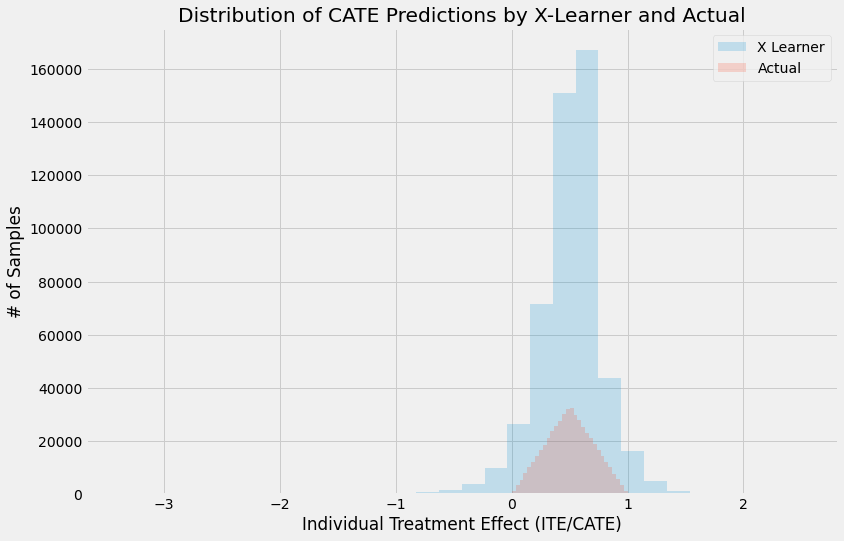

In [19]:
alpha =0.2
bins = 30
plt.figure(figsize = (12,8))
plt.hist(cate_x_test, alpha = alpha, bins = bins, label = "X Learner")
plt.hist(tau_test, alpha = alpha, bins = bins, label = "Actual")

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

# Validating CATE without TMLE

In [24]:
df = pd.DataFrame({
    'y':y_test, 
    "w":treatment_test, 
    'tau':tau_test, 
    "X-learner":cate_x_test, 
    "Actual": tau_test
})
# Note that "tau" and "Actual" are both tau_test

## Uplift Curve With Ground Truth

If true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model's CATE estimate.

In the figure below, the uplift curve of X-learner shows positive lift close to the optimal lift by the ground truth.

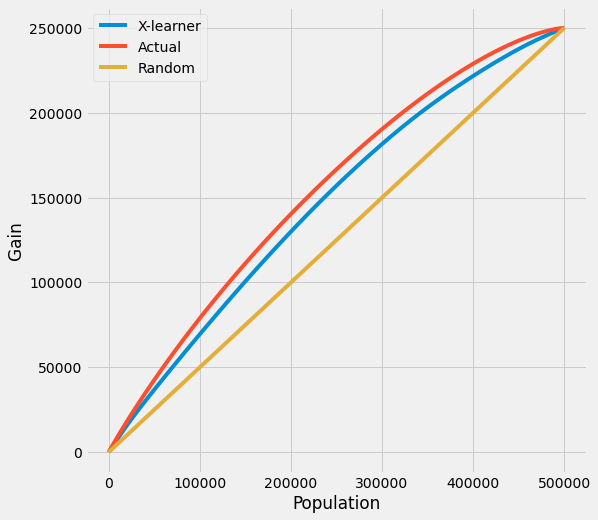

In [25]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

## Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model's CATE estimate.

In the figure below, the uplift curves of X-learner as well as the ground truth show no lift incorrectly.

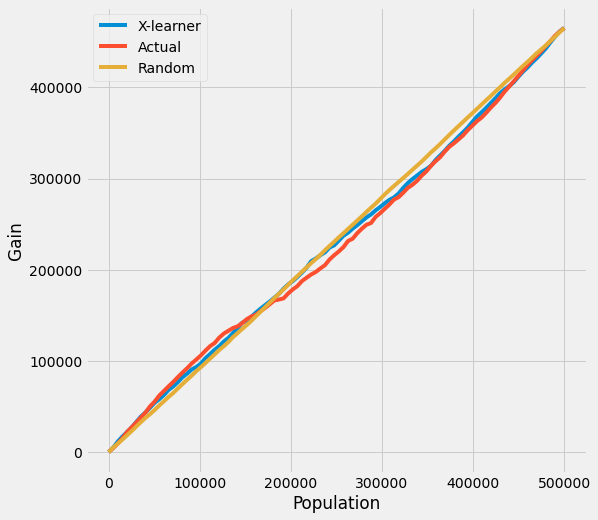

In [26]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

# TMLE

## Uplift Curve with TMLE as Ground Truth

By using TMLE as a proxy of the ground truth, the uplift curves of X-learner and the ground truth become close to the original using the ground truth.

In [28]:
n_fold = 5
kf = KFold(n_splits=n_fold)

In [30]:
df = pd.DataFrame({
    "y":y_test,
    "w":treatment_test,
    "p":e_test,
    "X-Learner":cate_x_test,
    "Actual": tau_test
})
# Note that we don't have "tau" column, but we have "p" which is the propensity

In [31]:
df.head()

,y,w,p,X-Learner,Actual
0,0.177753,0,0.100000,-0.549064,0.033258
1,5.513174,0,0.329710,0.533860,0.421832
2,2.686671,1,0.676990,0.717219,0.588493
3,5.434881,0,0.320180,0.376317,0.322184
4,-0.161428,0,0.439009,0.417925,0.415290


In [32]:
inference_cols = []
# Adding X_test independent covariate columns
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    df[col] = X_test[:,i]
    inference_cols.append(col)
    
df.head()

,y,w,p,X-Learner,Actual,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,0.177753,0,0.100000,-0.549064,0.033258,0.020490,0.046026,0.991870,0.123541,0.435273,0.131687,0.139887,0.783124,0.522208,0.130614
1,5.513174,0,0.329710,0.533860,0.421832,0.688274,0.155390,0.887186,0.581836,0.842651,0.514280,0.854751,0.446122,0.795257,0.742515
2,2.686671,1,0.676990,0.717219,0.588493,0.257423,0.919562,0.841629,0.265312,0.345890,0.839621,0.654126,0.170536,0.696014,0.700912
3,5.434881,0,0.320180,0.376317,0.322184,0.314512,0.329855,0.253469,0.201163,0.301250,0.652036,0.538327,0.041110,0.102342,0.878428
4,-0.161428,0,0.439009,0.417925,0.415290,0.582010,0.248570,0.648861,0.177277,0.223224,0.918715,0.856738,0.774285,0.139694,0.336974


In [33]:
inference_cols

['col_0',
 'col_1',
 'col_2',
 'col_3',
 'col_4',
 'col_5',
 'col_6',
 'col_7',
 'col_8',
 'col_9']

In [35]:
tmle_df = get_tmlegain(
    df, 
    inference_col = inference_cols, 
    outcome_col = "y", 
    treatment_col = "w", 
    p_col = "p",
    n_segment = 5,
    cv = kf,
    calibrate_propensity = True,
    ci = False
)

In [36]:
tmle_df

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
0.2,0.135514,0.158116,0.104503
0.4,0.270414,0.288566,0.209006
0.6,0.374591,0.394725,0.313510
0.8,0.466037,0.476125,0.418013
1.0,0.522516,0.522516,0.522516


## Uplift Curve without CI

Here we can directly use plot_tmle() function to generate the results and plot uplift curve

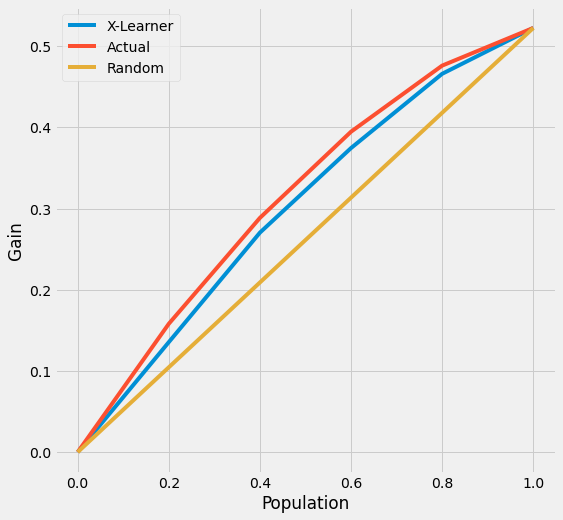

In [37]:
plot_tmlegain(df, inference_col = inference_cols, outcome_col ="y", treatment_col = "w", 
              p_col = "p", n_segment = 5, cv = kf, calibrate_propensity = True, ci = False)

# Uplift Curve with CI

No handles with labels found to put in legend.


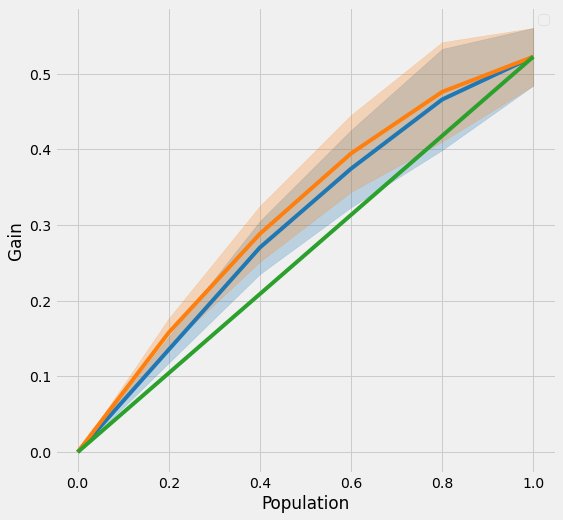

In [38]:
plot_tmlegain(df, inference_col = inference_cols, outcome_col ="y", treatment_col = "w", 
              p_col = "p", n_segment = 5, cv = kf, calibrate_propensity = True, ci = True)